In [14]:
# Cell: imports + helpers
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# helper for nicely showing DataFrames in this environment (may not be needed locally)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    _have_display = True
except Exception:
    _have_display = False

try:
    from IPython.display import display
except Exception:
    pass

def display_df(name, df):
    print(f"--- {name} (shape: {df.shape}) ---")
    if 'display' in globals():
        display(df.head(10))
    else:
        print(df.head(10))
    if _have_display:
        try:
            display_dataframe_to_user(name, df)
        except Exception:
            pass

def try_read(path):
    if os.path.exists(path):
        try:
            print('Loading', path)
            return pd.read_csv(path)
        except Exception as e:
            print('Error reading', path, e)
            return None
    else:
        return None


In [15]:
# Cell: load datasets (will create example files if not found)
df1 = try_read('dataset1.csv')
df2 = try_read('dataset2.csv')

if df1 is None or df2 is None:
    print('dataset1.csv or dataset2.csv not found. Creating example datasets at /mnt/data for demonstration.')
    np.random.seed(42)
    n1 = 200
    df1 = pd.DataFrame({
        'start_time': pd.date_range('2024-01-01 18:00', periods=n1, freq='20T'),
        'bat_landing_to_food': np.abs(np.random.normal(loc=5, scale=4, size=n1)).round(2),
        'habit': np.random.choice(['forage','scan','rush'], size=n1),
        'rat_period_start': pd.date_range('2024-01-01 18:05', periods=n1, freq='20T'),
        'rat_period_end': pd.date_range('2024-01-01 18:06', periods=n1, freq='20T'),
        'seconds_after_rat_arrival': np.random.randint(-60, 300, size=n1),
        'risk': np.random.choice([0,1], size=n1, p=[0.7,0.3]),
        'reward': np.random.choice([0,1], size=n1, p=[0.5,0.5]),
        'month': np.random.choice(['Jan','Feb','Mar'], size=n1),
        'sunset_time': pd.date_range('2024-01-01 18:00', periods=n1, freq='20T'),
        'hours_after_sunset': np.random.uniform(0,4,size=n1).round(2),
        'season': np.random.choice(['wet','dry'], size=n1)
    })
    n2 = 120
    df2 = pd.DataFrame({
        'time': pd.date_range('2024-01-01 18:00', periods=n2, freq='30T'),
        'month': np.random.choice(['Jan','Feb','Mar'], size=n2),
        'hours_after_sunset': np.random.uniform(0,4,size=n2).round(2),
        'bat_landing_number': np.random.poisson(lam=5, size=n2),
        'food_availability': np.random.uniform(0,100,size=n2).round(1),
        'rat_minutes': np.random.randint(0,180,size=n2),
        'rat_arrival_number': np.random.poisson(lam=2, size=n2)
    })
    df1.to_csv('/mnt/data/dataset1_example.csv', index=False)
    df2.to_csv('/mnt/data/dataset2_example.csv', index=False)
    print('Example files saved to /mnt/data/dataset1_example.csv and /mnt/data/dataset2_example.csv')
else:
    print('Both files loaded from current directory.')


Loading dataset1.csv
Loading dataset2.csv
Both files loaded from current directory.


In [16]:
# Cell: Preview datasets
display_df('dataset1 (preview)', df1)
display_df('dataset2 (preview)', df2)


--- dataset1 (preview) (shape: (907, 12)) ---


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0
5,30/12/2017 19:54,24.000000,rat,30/12/2017 19:50,30/12/2017 19:55,215,1,0,0,30/12/2017 16:45,3.155833,0
6,30/12/2017 19:54,13.000000,rat,30/12/2017 19:50,30/12/2017 19:55,253,1,0,0,30/12/2017 16:45,3.166389,0
7,26/12/2017 21:24,15.000000,rat,26/12/2017 21:22,26/12/2017 21:27,88,1,0,0,26/12/2017 16:43,4.684444,0
8,26/12/2017 21:24,6.000000,pick,26/12/2017 21:22,26/12/2017 21:27,113,0,1,0,26/12/2017 16:43,4.691389,0
9,26/12/2017 21:24,3.000000,fast,26/12/2017 21:22,26/12/2017 21:27,121,0,1,0,26/12/2017 16:43,4.693611,0


--- dataset2 (preview) (shape: (2123, 7)) ---


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.000000,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.000000,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.000000,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.000000,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.000000,0
5,26/12/2017 18:43,0,2.0,44,3.147265,0.000000,0
6,26/12/2017 19:13,0,2.5,41,3.000000,0.000000,0
7,26/12/2017 19:43,0,3.0,54,3.000000,0.000000,0
8,26/12/2017 20:13,0,3.5,32,3.000000,0.000000,0
9,26/12/2017 20:43,0,4.0,51,2.968874,1.283333,2


In [17]:
# Cell: dataset1 - info & summaries
print('\n== dataset1: info & basic stats ==')
print(df1.info())
print('\nNumerical summary:')
print(df1.describe(include='all'))



== dataset1: info & basic stats ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   start_time                 907 non-null    object 
 1   bat_landing_to_food        907 non-null    float64
 2   habit                      866 non-null    object 
 3   rat_period_start           907 non-null    object 
 4   rat_period_end             907 non-null    object 
 5   seconds_after_rat_arrival  907 non-null    int64  
 6   risk                       907 non-null    int64  
 7   reward                     907 non-null    int64  
 8   month                      907 non-null    int64  
 9   sunset_time                907 non-null    object 
 10  hours_after_sunset         907 non-null    float64
 11  season                     907 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 85.2+ KB
None

Numeri

In [18]:
# Cell: dataset1 - categorical counts
for col in ['risk','reward','season','month','habit']:
    if col in df1.columns:
        print(f'\nValue counts for {col}')
        print(df1[col].value_counts(dropna=False))




Value counts for risk
risk
0    458
1    449
Name: count, dtype: int64

Value counts for reward
reward
1    484
0    423
Name: count, dtype: int64

Value counts for season
season
1    756
0    151
Name: count, dtype: int64

Value counts for month
month
4    498
5    232
2     92
1     33
0     26
3     26
Name: count, dtype: int64

Value counts for habit
habit
fast                                                245
rat                                                 221
pick                                                139
NaN                                                  41
bat                                                  30
                                                   ... 
bat_fight_and_rat                                     1
rat_and_rat                                           1
not_sure_rat                                          1
501.0,358.4,636.2,423.4; 476.0,103.0,634.0,206.0      1
rat_and_bat_and_pick                                  1
Name: count, Length:

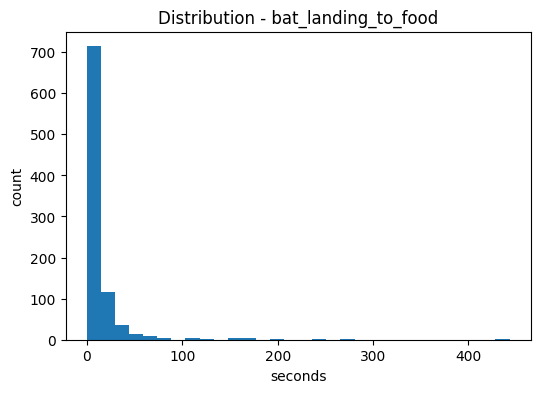

C:\Users\sande\AppData\Local\Temp\ipykernel_1064\3076210155.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


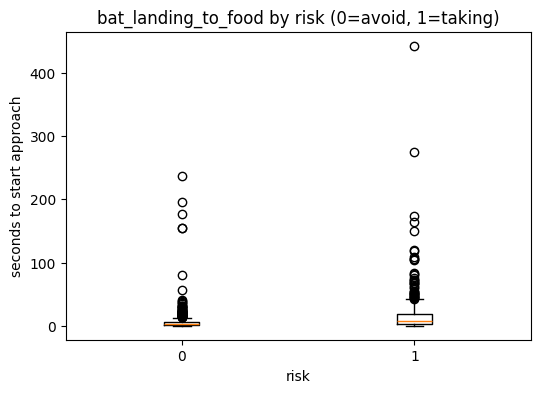


Mean seconds_after_rat_arrival by risk:
risk
0    277.598253
1    288.262806
Name: seconds_after_rat_arrival, dtype: float64


In [19]:
# Cell: dataset1 - distribution & boxplot
if 'bat_landing_to_food' in df1.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df1['bat_landing_to_food'].dropna(), bins=30)
    plt.title('Distribution - bat_landing_to_food')
    plt.xlabel('seconds')
    plt.ylabel('count')
    plt.show()

if set(['bat_landing_to_food','risk']).issubset(df1.columns):
    groups = [g.dropna().values for _,g in df1[['risk','bat_landing_to_food']].groupby('risk')['bat_landing_to_food']]
    labels = [str(x) for x in sorted(df1['risk'].dropna().unique())]
    plt.figure(figsize=(6,4))
    plt.boxplot(groups, labels=labels)
    plt.title('bat_landing_to_food by risk (0=avoid, 1=taking)')
    plt.xlabel('risk')
    plt.ylabel('seconds to start approach')
    plt.show()

if set(['seconds_after_rat_arrival','risk']).issubset(df1.columns):
    print('\nMean seconds_after_rat_arrival by risk:')
    print(df1.groupby('risk')['seconds_after_rat_arrival'].mean())


In [20]:
# Cell: dataset1 - inferential tests
# 1) T-test: compare bat_landing_to_food between risk groups (0 vs 1)
if set(['bat_landing_to_food','risk']).issubset(df1.columns):
    g0 = df1[df1['risk']==0]['bat_landing_to_food'].dropna()
    g1 = df1[df1['risk']==1]['bat_landing_to_food'].dropna()
    if len(g0)>2 and len(g1)>2:
        tstat, pval = stats.ttest_ind(g0, g1, equal_var=False, nan_policy='omit')
        print('T-test bat_landing_to_food | t =', round(tstat,4), ', p =', round(pval,4))
    else:
        print('Not enough data for t-test.')

# 2) Chi-square: association between risk and reward (both categorical 0/1)
if set(['risk','reward']).issubset(df1.columns):
    ct = pd.crosstab(df1['risk'], df1['reward'])
    print('\nContingency table (risk x reward):\n', ct)
    try:
        chi2, p, dof, exp = stats.chi2_contingency(ct)
        print('Chi-square: chi2 =', round(chi2,4), ', p =', round(p,4), ', dof =', dof)
    except Exception as e:
        print('Chi-square error:', e)

# 3) Logistic regression: Predicting risk (0/1) from seconds_after_rat_arrival and other covariates
if 'risk' in df1.columns:
    predictors = ['seconds_after_rat_arrival','hours_after_sunset','reward']
    available = [c for c in predictors if c in df1.columns]
    if 'season' in df1.columns:
        formula = 'risk ~ ' + ' + '.join(available) + ' + C(season)'
    else:
        formula = 'risk ~ ' + ' + '.join(available)
    try:
        df_log = df1.dropna(subset=['risk']+available)
        model = smf.logit(formula=formula, data=df_log).fit(disp=False)
        print('\nLogistic regression summary:\n')
        print(model.summary())
    except Exception as e:
        print('Logistic regression failed:', e)


T-test bat_landing_to_food | t = -5.0965 , p = 0.0

Contingency table (risk x reward):
 reward    0    1
risk            
0        72  386
1       351   98
Chi-square: chi2 = 352.8338 , p = 0.0 , dof = 1

Logistic regression summary:

                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                            4
Date:                Fri, 05 Sep 2025   Pseudo R-squ.:                  0.3074
Time:                        21:52:12   Log-Likelihood:                -435.40
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                 2.331e-82
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

In [21]:
# Cell: dataset2 - info & summaries
print('\n== dataset2: info & basic stats ==')
print(df2.info())
print('\nNumerical summary:')
print(df2.describe(include='all'))



== dataset2: info & basic stats ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                2123 non-null   object 
 1   month               2123 non-null   int64  
 2   hours_after_sunset  2123 non-null   float64
 3   bat_landing_number  2123 non-null   int64  
 4   food_availability   2123 non-null   float64
 5   rat_minutes         2123 non-null   float64
 6   rat_arrival_number  2123 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 116.2+ KB
None

Numerical summary:
                    time        month  hours_after_sunset  bat_landing_number  \
count               2123  2123.000000         2123.000000         2123.000000   
unique              2123          NaN                 NaN                 NaN   
top     26/12/2017 16:13          NaN                 NaN                 NaN   
freq

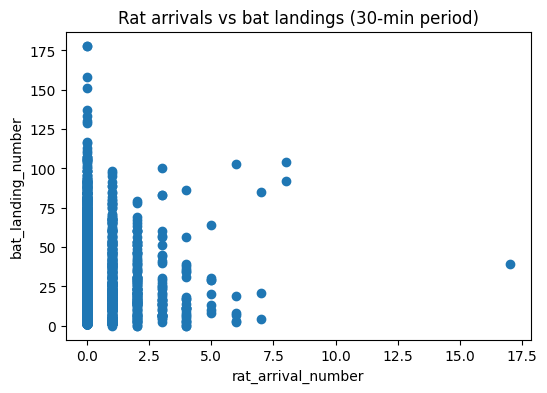


Pearson correlation between rat_arrival_number and bat_landing_number: r = -0.0735 , p = 0.0007


In [22]:
# Cell: dataset2 - scatter and correlation
if set(['rat_arrival_number','bat_landing_number']).issubset(df2.columns):
    plt.figure(figsize=(6,4))
    plt.scatter(df2['rat_arrival_number'], df2['bat_landing_number'])
    plt.xlabel('rat_arrival_number')
    plt.ylabel('bat_landing_number')
    plt.title('Rat arrivals vs bat landings (30-min period)')
    plt.show()

    clean = df2[['rat_arrival_number','bat_landing_number']].dropna()
    if len(clean) >= 3:
        corr, p = stats.pearsonr(clean['rat_arrival_number'], clean['bat_landing_number'])
        print('\nPearson correlation between rat_arrival_number and bat_landing_number: r =', round(corr,4), ', p =', round(p,4))
    else:
        print('Not enough data for correlation test.')


In [23]:
# Cell: dataset2 - OLS regression (bat_landing_number ~ rat_arrival_number + rat_minutes + hours_after_sunset + food_availability)
predictors = [c for c in ['rat_arrival_number','rat_minutes','hours_after_sunset','food_availability'] if c in df2.columns]
if 'bat_landing_number' in df2.columns and predictors:
    df_ols = df2[['bat_landing_number'] + predictors].dropna()
    if len(df_ols) >= 10:
        X = sm.add_constant(df_ols[predictors])
        y = df_ols['bat_landing_number']
        ols = sm.OLS(y, X).fit()
        print(ols.summary())
    else:
        print('Not enough rows for a robust regression (need at least ~10 rows after dropna).')
else:
    print('Required columns for OLS not present.')


                            OLS Regression Results                            
Dep. Variable:     bat_landing_number   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     20.66
Date:                Fri, 05 Sep 2025   Prob (F-statistic):           1.01e-16
Time:                        21:53:22   Log-Likelihood:                -9856.5
No. Observations:                2123   AIC:                         1.972e+04
Df Residuals:                    2118   BIC:                         1.975e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 39.4943      3